# Формализация задачи

**Для начала обсудим чем подобный спам может грозить бизнесу:**

- Спам, в котором предлагается оставлять хорошие отзывы за какую-то награду, может увеличить количество некорректных отзывов, что может уменьшить лоялность как среди пользовательей, так среди продавцов, из-за чего они могут выбрать площадки конкурентов
- Все виды данных спамов могут понизить качество отзывов, из-за чего покупатели не захотят прибегать к опции отзывов и выберут другую площадку.

**Формализация задачи:**

Нужно разработать алгоритм, позволяющий отличать фото отзыва, содержащего спам, от фото, несодержащего. В качестве спама различают фотографии:

  1) С рекламным текстом
  
  2) С предложением о заработке денег/вакансиях

  3) С просьбой перейти в телеграм-канал

  4) C никнеймами в соцсетях

  5) С номерами телефонов



# Загрузка Датасета

In [ ]:
# Загружаем нужные библиотеки
import os
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import copy
from torchvision.transforms import functional as F
from google.colab.patches import cv2_imshow
import numpy as np

In [ ]:
# У меня датасет хранится на гугл диске, поэтому подключаемся к нему
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Разветвлетления начинаются с этой директории
root_directory = r'/content/drive/MyDrive/WBTECH/08_5000'

In [ ]:
# Считываем пути изображений с каждой директории
directories = ['train', 'val', 'test']
categories = ['0', '1']

filepaths = {}

for directory in directories:
    for category in categories:
        directory_path = os.path.join(root_directory, directory, category)
        images_filepaths = sorted([os.path.join(directory_path, f) for f in os.listdir(directory_path)])
        filepaths[f'{directory}{category}_images_filepaths'] = images_filepaths

In [ ]:
# Проверка открываются ли изображения
for key, paths in tqdm(filepaths.items()):
    filepaths[key] = [i for i in paths if cv2.imread(i) is not None]

100%|██████████| 6/6 [15:27<00:00, 154.51s/it]


In [ ]:
# Объединяем оба класса
train_images_paths = [*filepaths['train0_images_filepaths'],
                      *filepaths['train1_images_filepaths']]
val_images_paths = [*filepaths['val0_images_filepaths'],
                      *filepaths['val1_images_filepaths']]
test_images_paths = [*filepaths['test0_images_filepaths'],
                      *filepaths['test1_images_filepaths']]

In [ ]:
# Перемешиваем классы
random.seed(42)
random.shuffle(train_images_paths)
random.shuffle(val_images_paths)
random.shuffle(test_images_paths)

In [ ]:
# Функия для отображения изображений и их лейблов (зеленый если верно)
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = min(len(images_filepaths) // cols, 3)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 12))
    for i, image_filepath in enumerate(random.sample(images_filepaths, rows*cols)):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
# Посмотрим изображения
display_image_grid(train_images_paths)

Output hidden; open in https://colab.research.google.com to view.

# EDA и трансформации

**Считываем изображения и трансформация**

In [ ]:
# Класс для считывания изображений и применения трансформаций
class FraudDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == '1':
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [ ]:
# Получаем трейн, вал и тест датасеты
train_dataset = FraudDataset(train_images_paths)
val_dataset = FraudDataset(val_images_paths)
test_dataset = FraudDataset(test_images_paths)

**Рассмотрим грейскейл датасет**

In [ ]:
# Грейскейл
transform = A.Compose([
    A.ToGray(p = 1),
])

gray_train = FraudDataset(train_images_paths, transform)

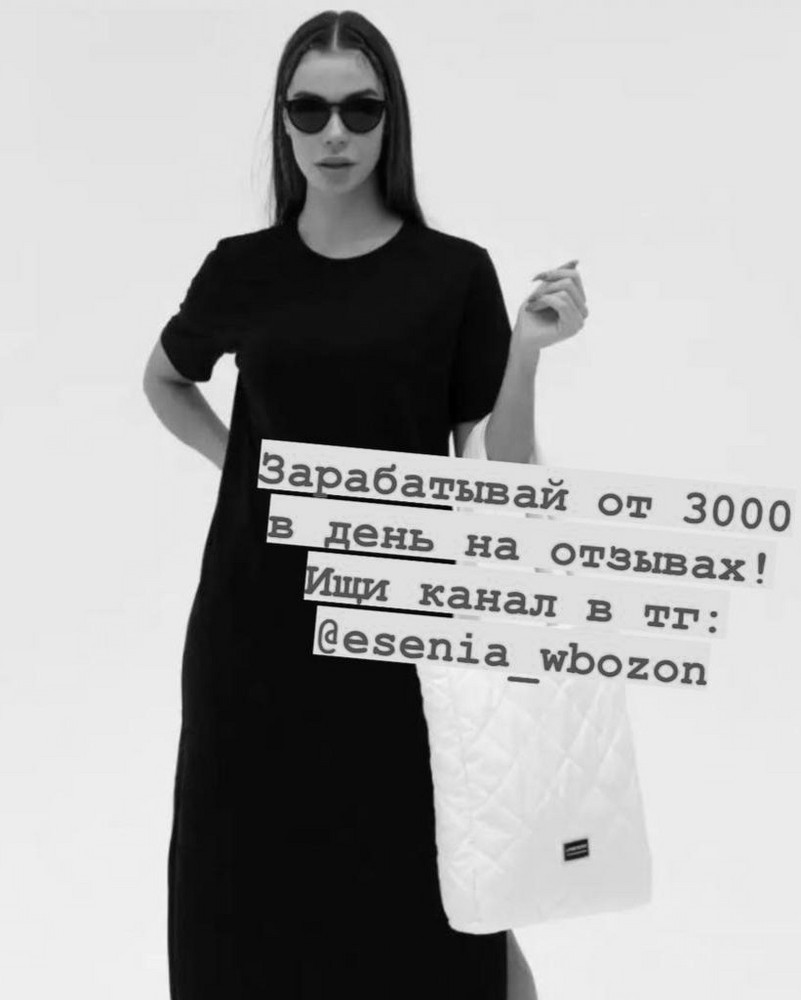

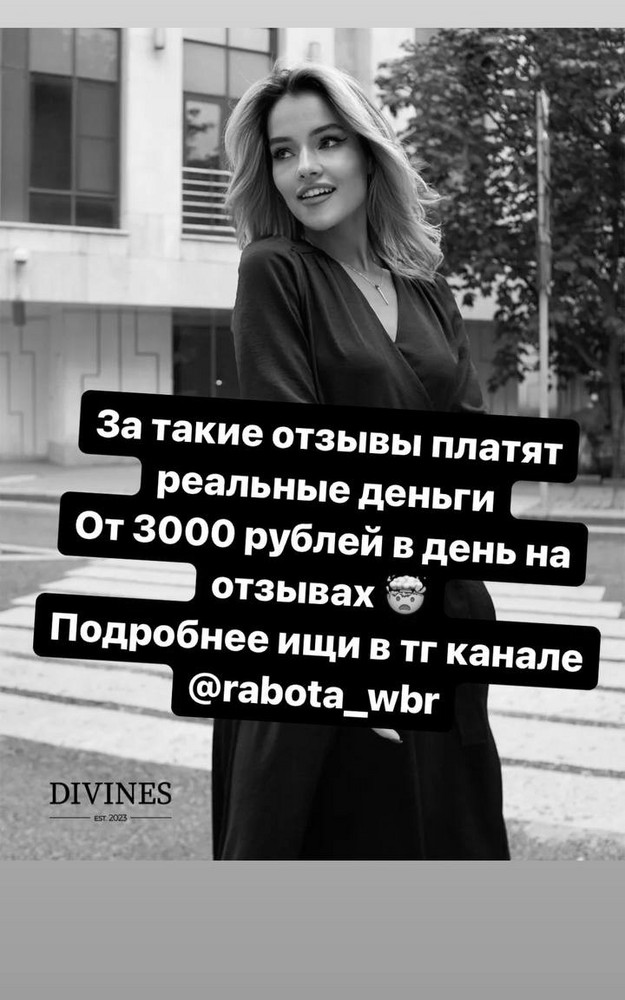

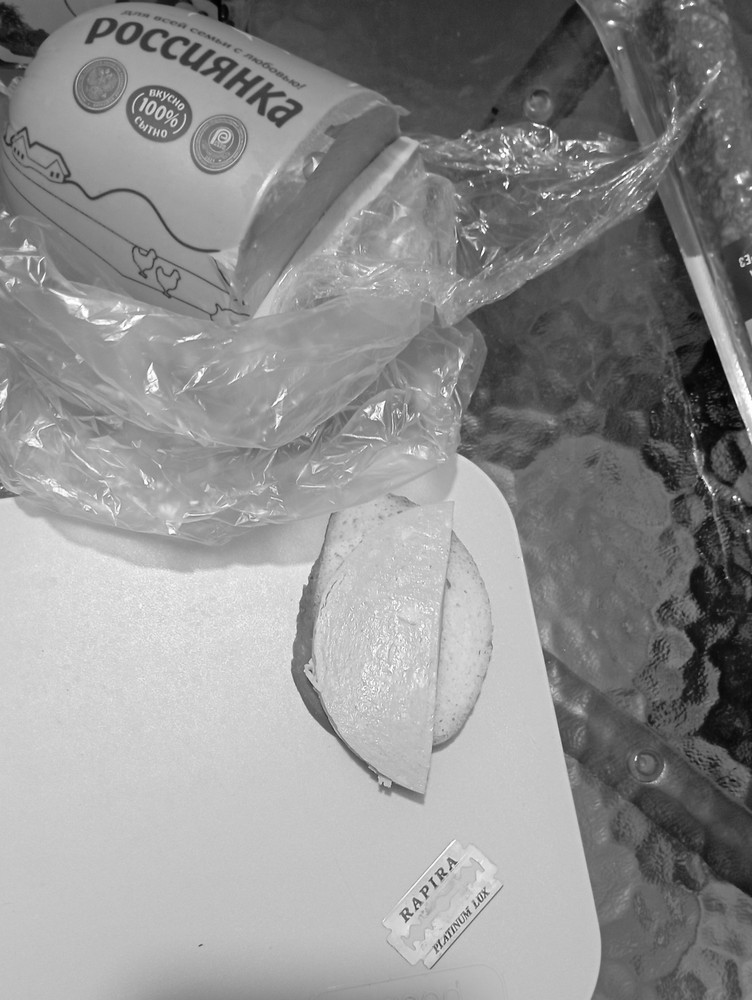

In [ ]:
# Посмотрим
cv2_imshow(gray_train[300][0])
cv2_imshow(gray_train[400][0])
cv2_imshow(gray_train[2300][0])
cv2.waitKey(0)
cv2.destroyAllWindows()

**Переходим к трансформациям, всего мы рассмотрим 3:**

- **Фильтр порогового значения**

- **Фильтр контуров**

- **Фильтр Собеля**

**И сравним их**

In [ ]:
# Фильтр порогового значения:
class Trashold(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        _, threshold_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
        return threshold_image, label

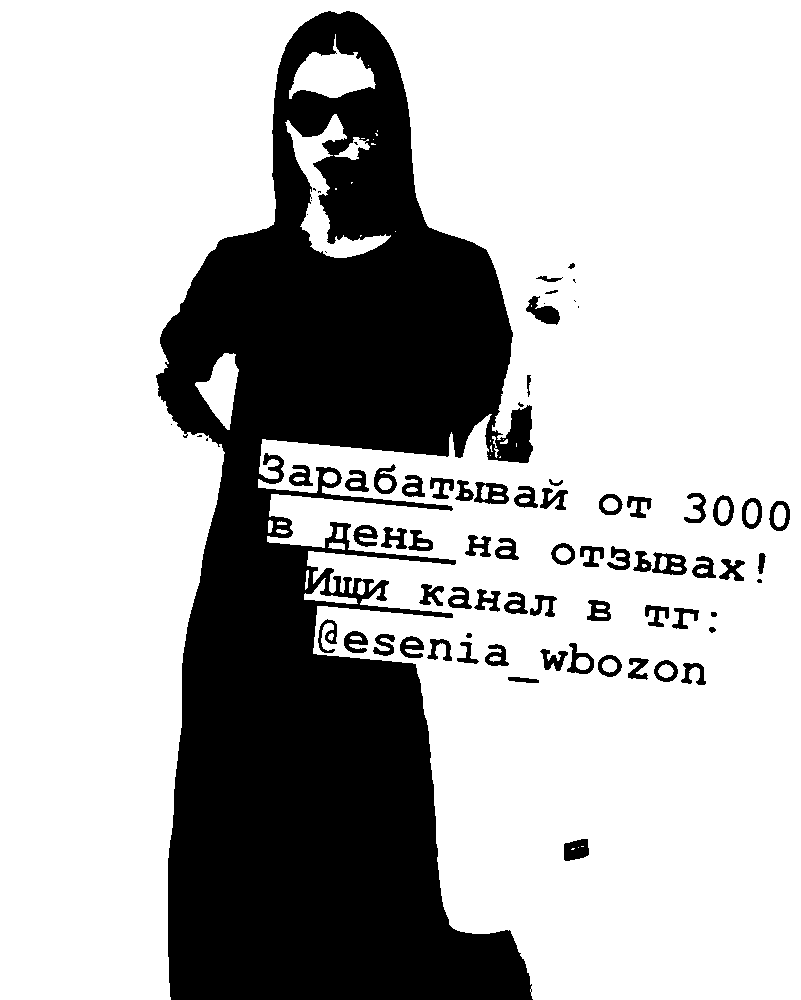

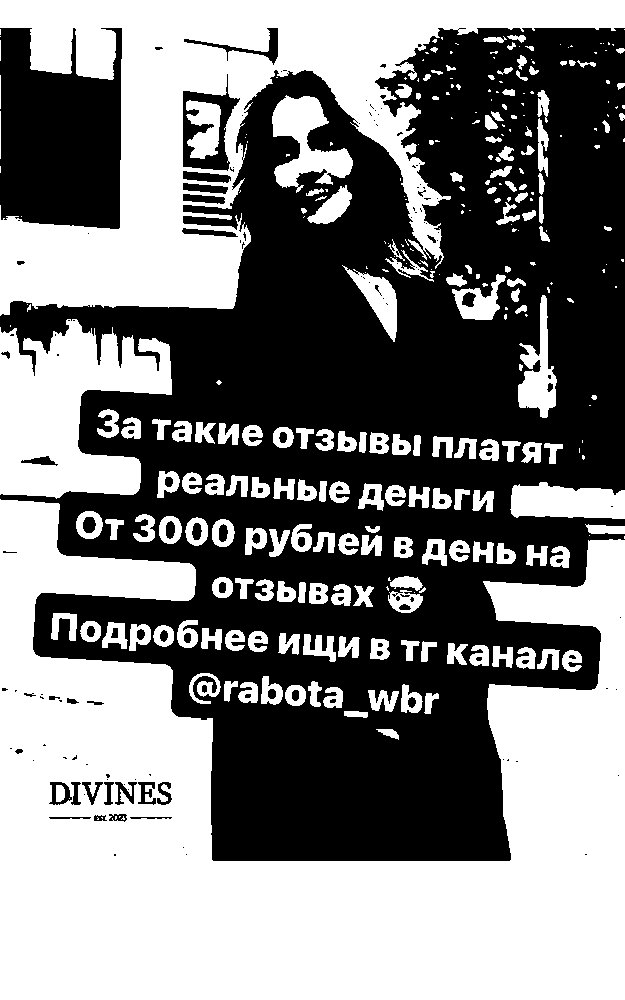

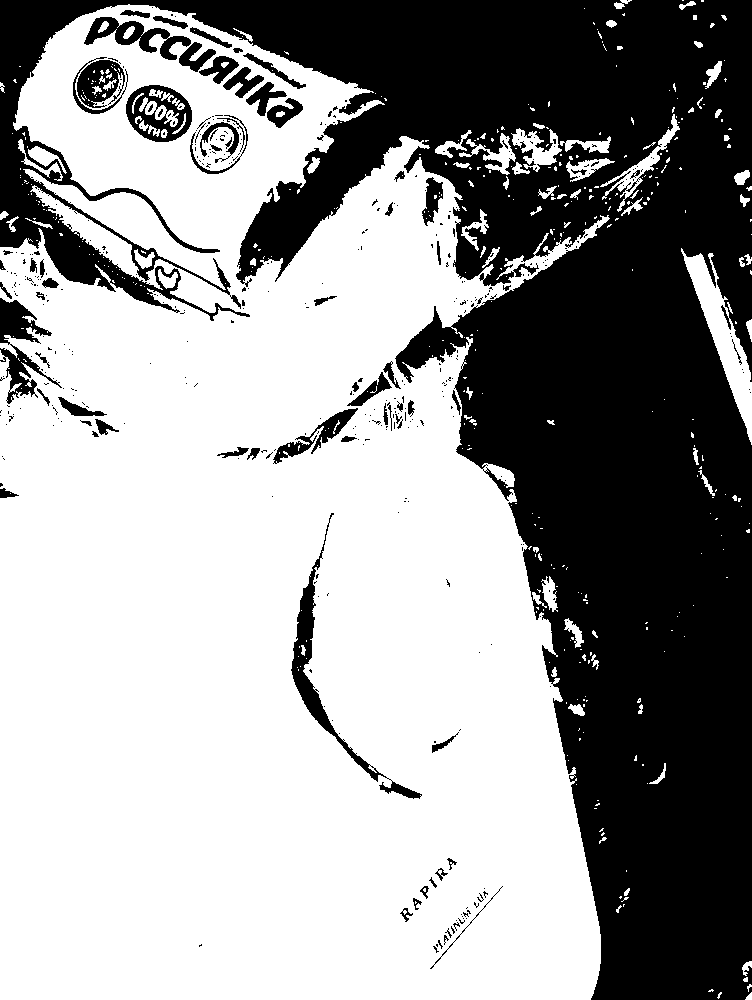

In [ ]:
# Посмотрим
trashold_dataset = Trashold(gray_train)

cv2_imshow(trashold_dataset[300][0])
cv2_imshow(trashold_dataset[400][0])
cv2_imshow(trashold_dataset[2300][0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# Фильтр контуров
class Edges(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        edges = cv2.Canny(image, 100, 200)

        return edges, label

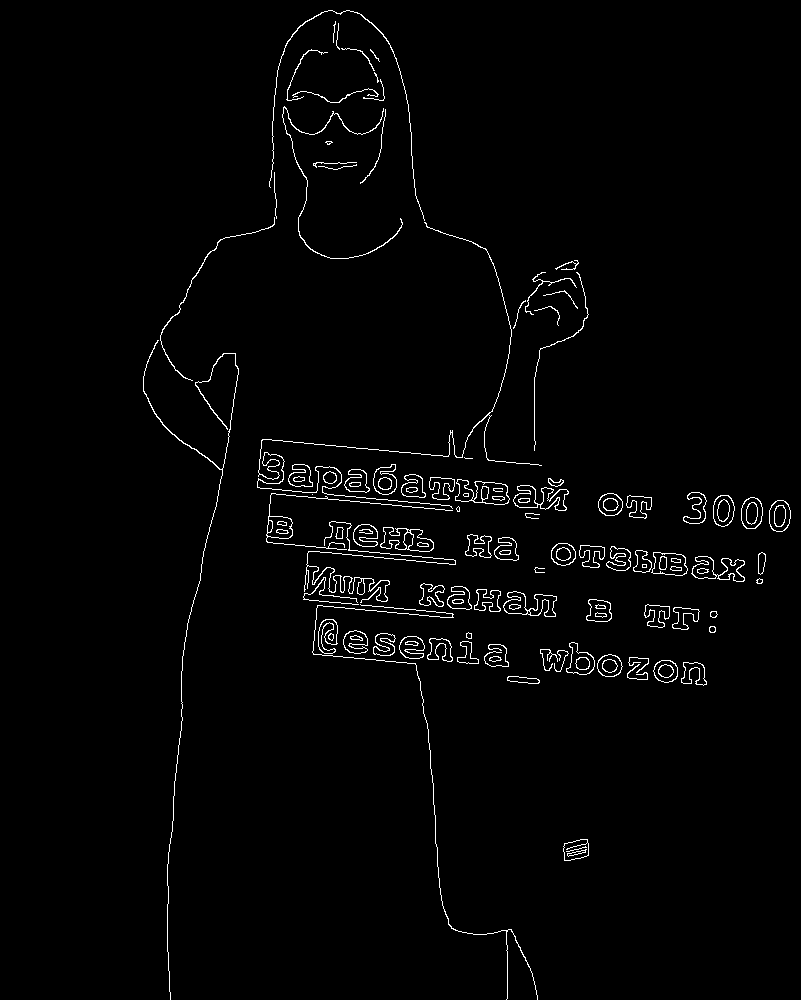

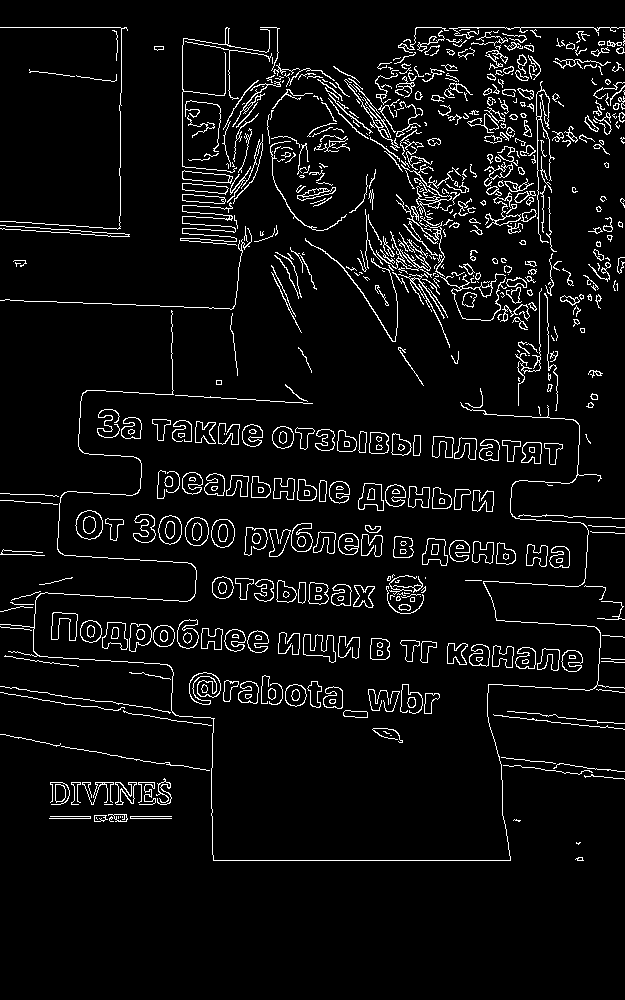

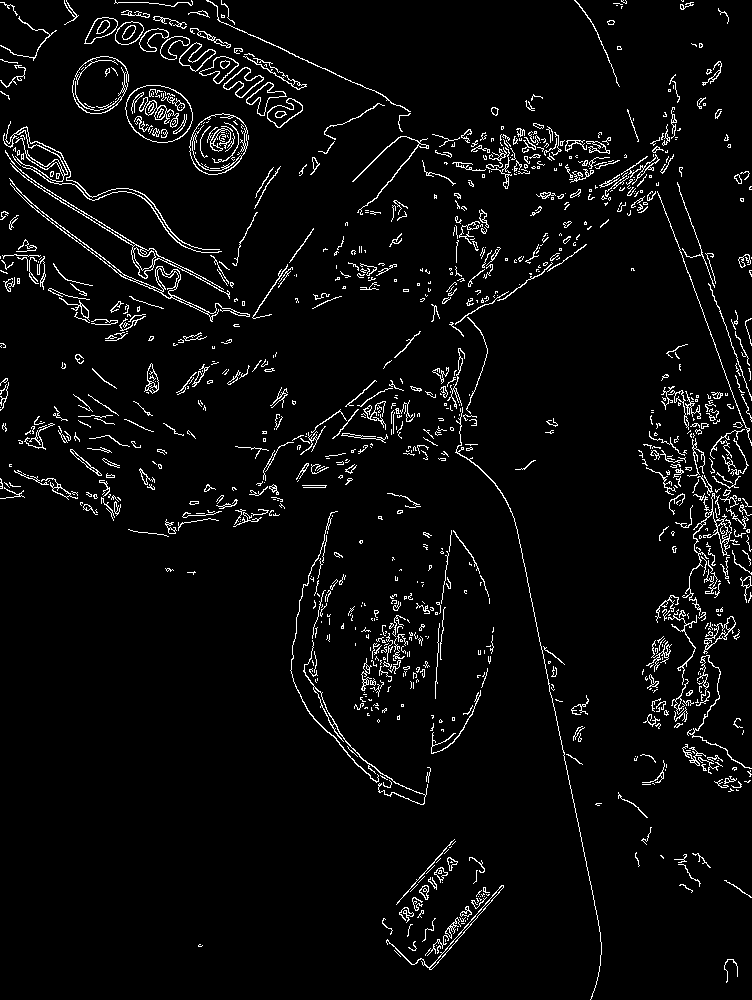

In [ ]:
# Посмотрим
edge_dataset = Edges(gray_train)

cv2_imshow(edge_dataset[300][0])
cv2_imshow(edge_dataset[400][0])
cv2_imshow(edge_dataset[2300][0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# Фильтр Собеля
class SobelFilterWrapper(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        # Применение фильтра Собеля
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        sobel_combined = cv2.addWeighted(np.absolute(sobel_x), 0.5, np.absolute(sobel_y), 0.5, 0)

        return sobel_combined, label

In [ ]:
# Посмотрим с RGB входов
sobel_dataset = SobelFilterWrapper(train_dataset)

cv2_imshow(sobel_dataset[300][0])
cv2_imshow(sobel_dataset[400][0])
cv2_imshow(sobel_dataset[2300][0])
cv2.waitKey(0)
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Посмотрим после грейскейл
sobel_train = SobelFilterWrapper(gray_train)

cv2_imshow(sobel_train[300][0])
cv2_imshow(sobel_train[400][0])
cv2_imshow(sobel_train[2300][0])
cv2.waitKey(0)
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

**Визуально отдаем предпочтения фильтру Собеля после грейскейла. Далее сравним его (уже не визуально) с изображениями без трансформаций**

In [ ]:
# Преобразуем валидационную и тестовую выборки
gray_val = FraudDataset(val_images_paths, transform)
sobel_val = SobelFilterWrapper(gray_val)
gray_test = FraudDataset(test_images_paths, transform)
sobel_test = SobelFilterWrapper(gray_test)

In [ ]:
# Нормализация
transform_norm = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

class Normalization(Dataset):
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [ ]:
# Отнормализованные датасеты
train_norm_dataset = Normalization(sobel_train, transform_norm)
val_norm_dataset = Normalization(sobel_val, transform_norm)
test_norm_dataset = Normalization(sobel_test, transform_norm)

In [ ]:
# Отнормализованные датасеты без применения фильтров для сравнения
train_orig_dataset = FraudDataset(train_images_paths, transform_norm)
val_orig_dataset = FraudDataset(val_images_paths, transform_norm)
test_orig_dataset = FraudDataset(test_images_paths, transform_norm)

# В качестве baseline попробуем ResNet

**Для проверки гипотезы о том, что фильтр Собеля может помочь в определении спама воспользуемся классификатором ResNet**

In [ ]:
# импортируем библиотеки
import torchvision.models as models
import torch
import torch.nn as nn
from collections import defaultdict

In [ ]:
# расчет accuracy
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [ ]:
# мониторинг метрик
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [ ]:
device = "cuda" if torch.cuda.is_available() else 'cpu'

params = {
    "model": "resnet50",
    "lr": 0.001,
    "device": device,
    "batch_size": 64,
    "num_workers": 2,
    "epochs": 10,
}

In [ ]:
model = getattr(models, params["model"])(pretrained=False, num_classes=1,)
model = model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

In [ ]:
# Даталоадеры (датасеты с трансформациями)
train_loader = DataLoader(
    train_norm_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    val_norm_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)
test_loader = DataLoader(
    test_norm_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [ ]:
# Обучение
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [ ]:
# Расчет метрик
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [ ]:
# Обучение
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.477 | Accuracy: 0.841: 100%|██████████| 55/55 [16:18<00:00, 17.79s/it]
Epoch: 1. Validation. Loss: 0.329 | Accuracy: 0.873: 100%|██████████| 12/12 [01:17<00:00,  6.43s/it]
Epoch: 2. Train.      Loss: 0.298 | Accuracy: 0.883: 100%|██████████| 55/55 [16:01<00:00, 17.47s/it]
Epoch: 2. Validation. Loss: 0.375 | Accuracy: 0.876: 100%|██████████| 12/12 [01:17<00:00,  6.44s/it]
Epoch: 3. Train.      Loss: 0.240 | Accuracy: 0.907: 100%|██████████| 55/55 [16:01<00:00, 17.49s/it]
Epoch: 3. Validation. Loss: 0.267 | Accuracy: 0.895: 100%|██████████| 12/12 [01:19<00:00,  6.63s/it]
Epoch: 4. Train.      Loss: 0.212 | Accuracy: 0.923: 100%|██████████| 55/55 [16:12<00:00, 17.67s/it]
Epoch: 4. Validation. Loss: 0.332 | Accuracy: 0.875: 100%|██████████| 12/12 [01:17<00:00,  6.46s/it]
Epoch: 5. Train.      Loss: 0.193 | Accuracy: 0.930: 100%|██████████| 55/55 [16:01<00:00, 17.49s/it]
Epoch: 5. Validation. Loss: 0.503 | Accuracy: 0.814: 100%|██████████| 12/12 [01:19<00:00,  

In [ ]:
validate(test_loader, model, criterion, 10, params)

Epoch: 10. Validation. Loss: 0.914 | Accuracy: 0.854: 100%|██████████| 12/12 [01:19<00:00,  6.61s/it]


**Итого, на тестовой выборке ResNet с датасетом с трансформациями показазал accuracy 0.913, что для baseline неплохо. Другие метрики не расчитывались, так как цель - проверить влияют ли трансформации на качество предсказывания**

In [ ]:
train_orig_loader = DataLoader(
    train_orig_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_orig_loader = DataLoader(
    val_orig_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)
test_orig_loader = DataLoader(
    test_orig_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [ ]:
model_orig = getattr(models, params["model"])(pretrained=False, num_classes=1,)
model_orig = model_orig.to(params["device"])
optimizer_orig = torch.optim.Adam(model_orig.parameters(), lr=params["lr"])

In [ ]:
for epoch in range(1, params["epochs"] + 1):
    train(train_orig_loader, model_orig, criterion, optimizer_orig, epoch, params)
    validate(val_orig_loader, model_orig, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.440 | Accuracy: 0.838: 100%|██████████| 55/55 [14:06<00:00, 15.38s/it]
Epoch: 1. Validation. Loss: 0.387 | Accuracy: 0.832: 100%|██████████| 12/12 [01:00<00:00,  5.06s/it]
Epoch: 2. Train.      Loss: 0.299 | Accuracy: 0.890: 100%|██████████| 55/55 [14:17<00:00, 15.59s/it]
Epoch: 2. Validation. Loss: 1.231 | Accuracy: 0.618: 100%|██████████| 12/12 [01:02<00:00,  5.20s/it]
Epoch: 3. Train.      Loss: 0.319 | Accuracy: 0.894: 100%|██████████| 55/55 [14:09<00:00, 15.44s/it]
Epoch: 3. Validation. Loss: 0.384 | Accuracy: 0.839: 100%|██████████| 12/12 [01:01<00:00,  5.12s/it]
Epoch: 4. Train.      Loss: 0.221 | Accuracy: 0.927: 100%|██████████| 55/55 [14:03<00:00, 15.33s/it]
Epoch: 4. Validation. Loss: 0.273 | Accuracy: 0.909: 100%|██████████| 12/12 [01:02<00:00,  5.18s/it]
Epoch: 5. Train.      Loss: 0.222 | Accuracy: 0.919: 100%|██████████| 55/55 [13:58<00:00, 15.25s/it]
Epoch: 5. Validation. Loss: 0.657 | Accuracy: 0.824: 100%|██████████| 12/12 [00:59<00:00,  

In [ ]:
validate(test_orig_loader, model_orig, criterion, 10, params)

Epoch: 10. Validation. Loss: 0.332 | Accuracy: 0.910: 100%|██████████| 12/12 [01:00<00:00,  5.06s/it]


**Удивительно, но к сожалению, гипотеза не подтвердилась и без трансформацией предсказывается не хуже**

# Воспользуемся EasyOCR

In [ ]:
! pip install easyocr

In [ ]:
import easyocr

**В этом блоке мы поиграемся с easyocr и наивно проверим есть ли очевидная разница при обучении с трансформацией и без (просто будем считать, везде где обнаружились слова спамом, что заведомо неправильно)**

In [ ]:
reader = easyocr.Reader(['ru', 'en'])

text_indexes = []
wrds_set = set()

for i, image_path in tqdm(enumerate(test_images_paths)):
    wrds_lst = reader.readtext(image_path, detail=0)
    if wrds_lst:
        text_indexes.append(i)
        wrds_set.update(wrds_lst)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

750it [2:38:08, 12.65s/it]


In [ ]:
acc = 0
for i, target in enumerate(test_dataset):
    if target[1] and (i in text_indexes):
        acc += 1
print(acc / len(test_dataset))

with open("text_indexes.txt", "w") as file:
    for item in text_indexes:
        file.write(item + "\n")

with open("wrds_set.txt", "w") as file:
    for item in wrds_set:
        file.write(item + "\n")

0.19866666666666666

In [ ]:
from PIL import Image
import numpy as np

for i, image in tqdm(enumerate(sobel_test)):
    image = image[0].astype(np.uint8)  # Преобразование типа данных в uint8
    image_local = Image.fromarray(image)
    image_local.save(f'sobel_test{i}.jpg')

750it [00:48, 15.44it/s]


In [ ]:
text_indexes_sobel = []
wrds_set_sobel = set()

for i in tqdm(range(len(sobel_test))):
    wrds_lst = reader.readtext(f'sobel_test{i}.jpg', detail=0)
    if wrds_lst:
        text_indexes_sobel.append(i)
        wrds_set_sobel.update(wrds_lst)

100%|██████████| 750/750 [2:37:37<00:00, 12.61s/it]


In [ ]:
acc = 0
for i, target in enumerate(test_dataset):
    if target[1] and (i in text_indexes_sobel):
        acc += 1
print(acc / len(test_dataset))

with open("text_indexes_sobel.txt", "w") as file:
    for item in text_indexes:
        file.write(item + "\n")

with open("wrds_set_sobel.txt", "w") as file:
    for item in wrds_set_sobel:
        file.write(item + "\n")

NameError: name 'test_dataset' is not defined

**Слетело подключение, но оно  выдавало 0.199**

**Таким образом, значимых отличий нет при наивном сравнении (хотелось бы сделать ненаивное сравнение, однако collab отобрал у меня GPU, а из-за того что появился новый датасет, то не хотелось бы пересчитывать этот)**
